In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,text,inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite", echo=False)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table

measurement = Base.classes.measurement
station = Base.classes.station

In [11]:
#view column names and data types of measurement table
inspector = inspect(engine)
inspector.get_table_names()
columns_meau= inspector.get_columns('measurement')
for c in columns_meau:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
#view column names and data types of station table
inspector = inspect(engine)
inspector.get_table_names()
columns_sta= inspector.get_columns('station')
for c in columns_sta:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [15]:
# Find the most recent date in the data set.
mr_date = session.query(measurement.date).order_by(measurement.date.desc()).first().date
mr_date


'2017-08-23'

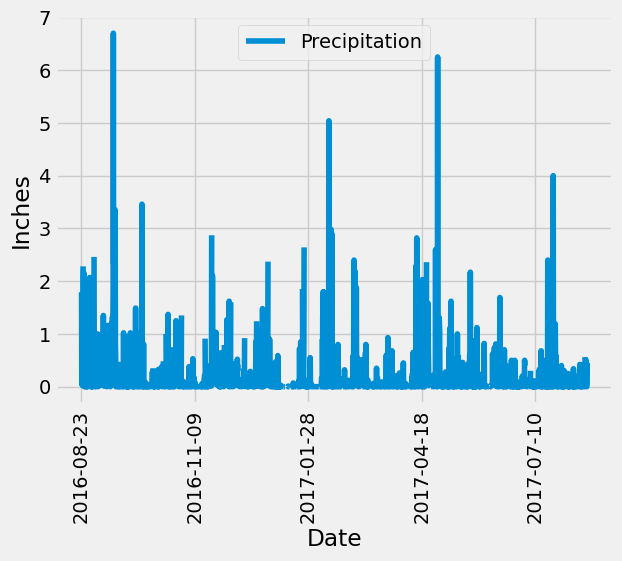

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
oy_date = dt.datetime.strptime(mr_date,'%Y-%m-%d') - dt.timedelta(days=366)


# Perform a query to retrieve the data and precipitation scores

data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= oy_date)

# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(data,columns=['Date', 'Precipitation'] )

# Sort the dataframe by date

sorted_df = df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data

sorted_df.plot(x='Date',y='Precipitation')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()


In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
s_statistics = sorted_df.describe()
s_statistics

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number of stations in the dataset

session.query(measurement.station).distinct().count()


9

In [19]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
tn_stations = session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

tn_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
m = list(tn_stations[0])
ma_station_id = m[0]
ma_station_id

sel = [func.min(measurement.tobs), 
       func.max(measurement.tobs), 
       func.avg(measurement.tobs), 
       ]
temp_masi = session.query(*sel).\
    filter(measurement.station == ma_station_id).all()
temp_masi

[(54.0, 85.0, 71.66378066378067)]

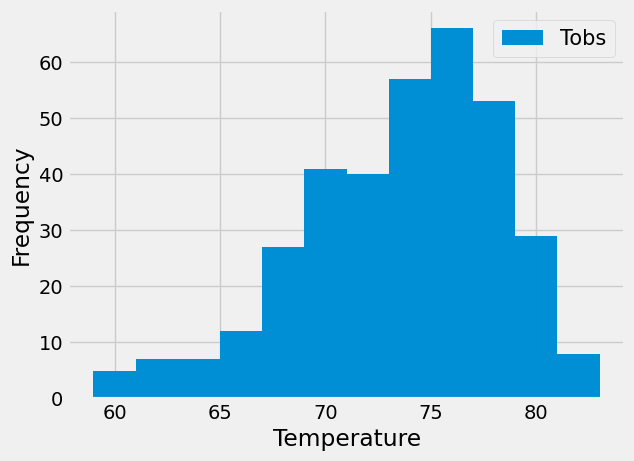

In [41]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
y_temp = session.query(measurement.tobs).\
        filter(measurement.station == ma_station_id).\
        filter(measurement.date >= oy_date).all()
df_temp = pd.DataFrame(y_temp)
plt.hist(df_temp, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['Tobs'],fontsize=15)
plt.show()

# Close Session

In [22]:
# Close Session
session.close()